In [ ]:
from functions import *
import glob
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from time import time

In [ ]:
IMAGE_DIR = "./data/Chinese_MNIST/data/data"

def load():
    file_list = glob.glob(IMAGE_DIR + "/*.jpg")
    X = []
    Y = []

    for fname in file_list:
        with Image.open(fname) as img:
            np_img = np.array(img).flatten()
        label = int(os.path.split(fname)[-1].split('.')[0].split('_')[3])-1

        X.append(np_img)
        Y.append(label)

    return(np.array(X), np.array(Y))

def get_dataset(i):
    X = None
    Y = None 
    if i == 0: #Sign Language MNIST 
        train_df = pd.read_csv("./data/Sign_Language_MNIST/sign_mnist_train.csv")
        test_df = pd.read_csv("./data/Sign_Language_MNIST/sign_mnist_test.csv")
        
        Ytrain = train_df['label']
        Ytest = test_df['label']
        del train_df['label']
        del test_df['label']
        
        Xtrain = train_df.values
        Xtest = test_df.values
        X = np.append(Xtrain, Xtest, 0)
        Y = np.append(Ytrain, Ytest, 0)
        
    elif i == 1:#Chinese MNIST 
        X, Y = load()
        
    elif i == 2: #Fashion MNIST
        (Xtrain, Ytrain), (Xtest, Ytest) = fashion_mnist.load_data()
        Xtrain = Xtrain.reshape((len(Xtrain), np.prod(Xtrain.shape[1:])))
        Xtest = Xtest.reshape((len(Xtest), np.prod(Xtest.shape[1:])))
        X = np.append(Xtrain, Xtest, 0)
        Y = np.append(Ytrain, Ytest, 0)
        
    return (X, Y)

In [6]:
"""
Here we test the performace of our model with different amounts of training data
"""
from time import time

all_train_accuracy_ratio = list()
all_testing_accuracy_ratio = list()

batches = [x / 10 for x in range(1, 11, 1)]

for batch_mult in batches:
    batch_train_accuracy = list()
    batch_test_accuracy = list()
    
    for dataset in range(3):
        hard_start = time()

        X, Y = get_dataset(dataset)
        trainSizes = [x / 10 for x in range(1, 10, 1)] # Create a list of [0.5, ..., 0.9] If x < 0.5 we get an out of bounds error on the weights

        train_accuracy = []
        test_accuracy = []

        for trainRatio in trainSizes:
            start = time()
            print(f"Dataset: {dataset}; Batch Size: len(X)*{batch_mult}; Ratio: {trainRatio:.2%}")
            
            Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=trainRatio, random_state=2021)

            model = Boost(n_estimators=500, base_learner=ShallowTree()).update_fit(Xtrain,Ytrain, verbose=100, batch_size=round(len(Xtrain)*batch_mult))

            train_acc = model.accuracy(model.predict(Xtrain[:1000,]),Ytrain[:1000,])
            train_accuracy.append(train_acc)
            print(f"Ratio: {trainRatio:.2%}\n\t Train Accuracy: {train_acc:.2%}")
            test_acc = model.accuracy(model.predict(Xtest[:1000,]),Ytest[:1000,])
            test_accuracy.append(test_acc)
            print(f"Ratio: {trainRatio:.2%}\n\t Test Accuracy: {test_acc:.2%}")
            print(f"{time()-start:.2f} seconds elapsed")

        batch_train_accuracy.append(train_accuracy)
        batch_test_accuracy.append(test_accuracy)
        print(f"{time()-hard_start:.2f} seconds to run")
    
    all_train_accuracy_ratio.append(batch_train_accuracy)
    all_testing_accuracy_ratio.append(batch_test_accuracy)

KeyboardInterrupt: 

Dataset: 0; Batch Size: len(X)*0.1; Treesize: 1
Accuracy/Loss 50 (45.90%/1003.121 in 0.31 seconds) after 33.73 seconds
Reshuffling...
Accuracy/Loss 100 (41.43%/1002.239 in 0.60 seconds) after 69.78 seconds
Accuracy/Loss 150 (51.54%/1002.017 in 0.32 seconds) after 105.86 seconds
Reshuffling...
Accuracy/Loss 200 (49.64%/1001.248 in 0.44 seconds) after 145.16 seconds
Accuracy/Loss 250 (52.45%/1001.691 in 0.40 seconds) after 184.54 seconds


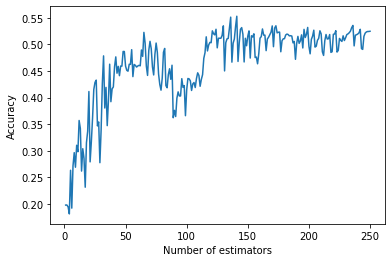

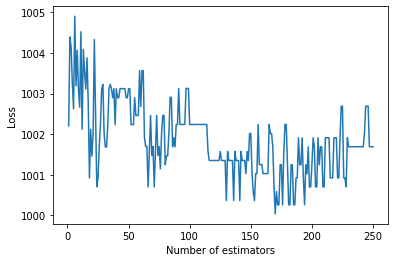

Percent correct with training set and tree size 1: 52.32%
Percent correct with test set and tree size 1: 51.63%
241.56 seconds elapsed
Dataset: 0; Batch Size: len(X)*0.1; Treesize: 2
Accuracy/Loss 50 (66.66%/1001.287 in 0.35 seconds) after 47.85 seconds
Reshuffling...
Accuracy/Loss 100 (68.06%/1001.276 in 0.33 seconds) after 97.57 seconds
Accuracy/Loss 150 (72.74%/1001.047 in 0.32 seconds) after 142.53 seconds
Reshuffling...
Accuracy/Loss 200 (73.42%/1001.046 in 0.32 seconds) after 185.70 seconds
Accuracy/Loss 250 (74.18%/1001.045 in 0.34 seconds) after 230.21 seconds


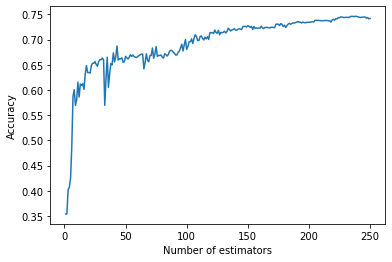

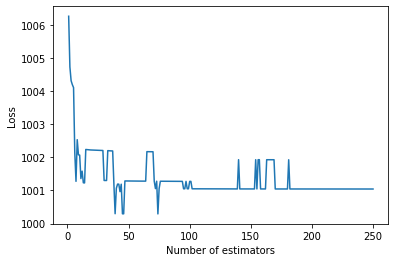

Percent correct with training set and tree size 2: 74.42%
Percent correct with test set and tree size 2: 36.67%
281.64 seconds elapsed
Dataset: 0; Batch Size: len(X)*0.1; Treesize: 3
Accuracy/Loss 50 (73.84%/1000.431 in 0.33 seconds) after 51.55 seconds
Reshuffling...
Accuracy/Loss 100 (74.94%/1000.414 in 0.33 seconds) after 107.27 seconds
Accuracy/Loss 150 (77.70%/1001.401 in 0.39 seconds) after 166.69 seconds
Reshuffling...
Accuracy/Loss 200 (77.92%/1001.395 in 0.33 seconds) after 227.03 seconds
Accuracy/Loss 250 (78.34%/1001.391 in 0.40 seconds) after 285.48 seconds


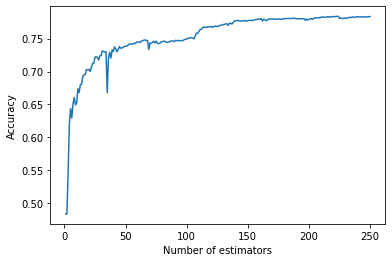

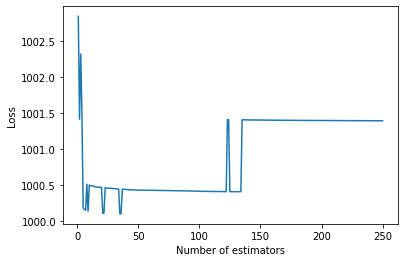

Percent correct with training set and tree size 3: 78.42%
Percent correct with test set and tree size 3: 25.75%
344.88 seconds elapsed
Dataset: 0; Batch Size: len(X)*0.1; Treesize: 4
Accuracy/Loss 50 (75.98%/1001.442 in 0.32 seconds) after 63.42 seconds
Reshuffling...
Accuracy/Loss 100 (77.24%/1002.275 in 0.32 seconds) after 125.15 seconds
Accuracy/Loss 150 (79.91%/1001.672 in 0.33 seconds) after 185.15 seconds
Reshuffling...
Accuracy/Loss 200 (80.39%/1000.658 in 0.37 seconds) after 247.21 seconds
Accuracy/Loss 250 (81.08%/1000.655 in 0.32 seconds) after 310.24 seconds


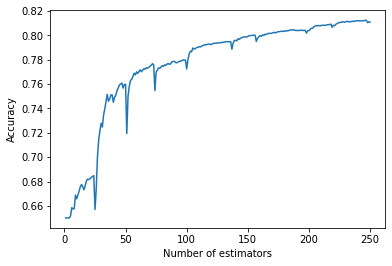

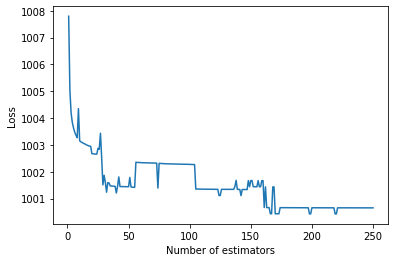

Percent correct with training set and tree size 4: 81.32%
Percent correct with test set and tree size 4: 20.15%
361.64 seconds elapsed
Dataset: 0; Batch Size: len(X)*0.1; Treesize: 5
Accuracy/Loss 50 (76.40%/1000.777 in 0.32 seconds) after 68.00 seconds
Reshuffling...
Accuracy/Loss 100 (78.49%/1000.722 in 0.32 seconds) after 136.32 seconds
Accuracy/Loss 150 (81.03%/1000.691 in 0.32 seconds) after 206.45 seconds
Reshuffling...
Accuracy/Loss 200 (81.82%/1000.679 in 0.33 seconds) after 274.59 seconds
Accuracy/Loss 250 (82.49%/1000.674 in 0.34 seconds) after 343.91 seconds


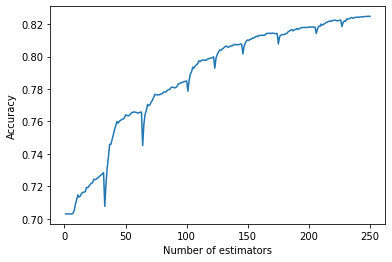

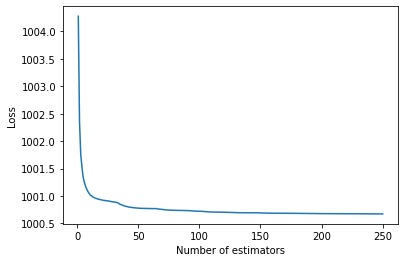

Percent correct with training set and tree size 5: 83.33%
Percent correct with test set and tree size 5: 16.39%
396.15 seconds elapsed
Dataset: 0; Batch Size: len(X)*0.1; Treesize: 6
Accuracy/Loss 50 (78.16%/1001.935 in 0.33 seconds) after 77.96 seconds
Reshuffling...
Accuracy/Loss 100 (81.09%/1001.776 in 0.33 seconds) after 156.03 seconds
Accuracy/Loss 150 (83.34%/1001.729 in 0.33 seconds) after 233.81 seconds
Reshuffling...
Accuracy/Loss 200 (84.28%/1001.703 in 0.33 seconds) after 311.60 seconds
Accuracy/Loss 250 (84.84%/1000.686 in 0.33 seconds) after 389.11 seconds


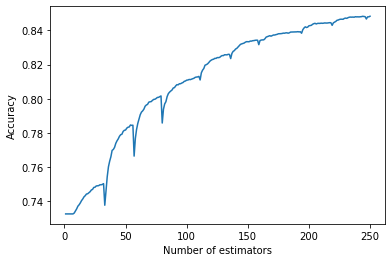

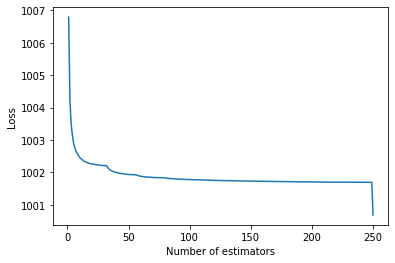

Percent correct with training set and tree size 6: 85.55%
Percent correct with test set and tree size 6: 13.93%
441.16 seconds elapsed
Dataset: 0; Batch Size: len(X)*0.1; Treesize: 7
Accuracy/Loss 50 (79.02%/1001.677 in 0.32 seconds) after 85.89 seconds
Reshuffling...
Accuracy/Loss 100 (82.71%/1000.507 in 0.33 seconds) after 171.92 seconds
Accuracy/Loss 150 (85.07%/1000.722 in 0.33 seconds) after 258.53 seconds
Reshuffling...
Accuracy/Loss 200 (85.83%/1000.710 in 0.32 seconds) after 344.75 seconds
Accuracy/Loss 250 (86.34%/1000.479 in 0.33 seconds) after 434.10 seconds


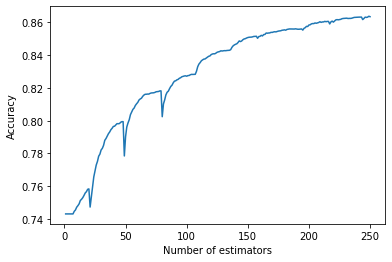

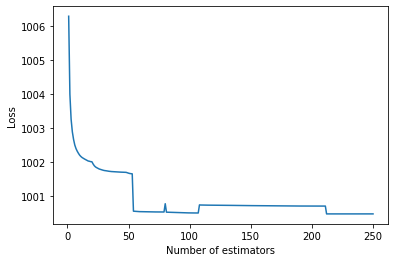

Percent correct with training set and tree size 7: 87.11%
Percent correct with test set and tree size 7: 12.09%
493.08 seconds elapsed
Dataset: 0; Batch Size: len(X)*0.1; Treesize: 8
Accuracy/Loss 50 (81.05%/1000.873 in 0.38 seconds) after 107.31 seconds
Reshuffling...
Accuracy/Loss 100 (84.10%/1000.774 in 0.32 seconds) after 212.30 seconds
Accuracy/Loss 150 (85.96%/1000.512 in 0.33 seconds) after 307.66 seconds
Reshuffling...
Accuracy/Loss 200 (86.83%/1000.497 in 0.40 seconds) after 416.43 seconds
Accuracy/Loss 250 (87.16%/1000.494 in 0.33 seconds) after 522.15 seconds


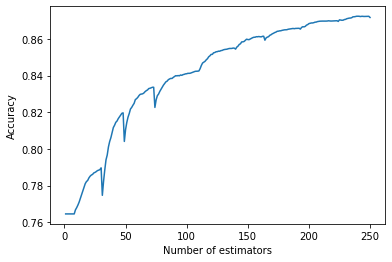

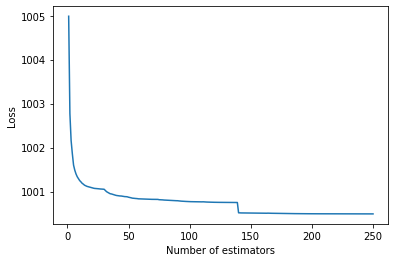

Percent correct with training set and tree size 8: 87.81%
Percent correct with test set and tree size 8: 10.70%
578.55 seconds elapsed
Dataset: 0; Batch Size: len(X)*0.1; Treesize: 9
Accuracy/Loss 50 (82.33%/1001.364 in 0.56 seconds) after 115.53 seconds
Reshuffling...
Accuracy/Loss 100 (84.31%/1001.260 in 0.36 seconds) after 234.29 seconds
Accuracy/Loss 150 (86.42%/1000.197 in 0.33 seconds) after 346.96 seconds
Reshuffling...
Accuracy/Loss 200 (87.27%/1000.188 in 0.35 seconds) after 457.65 seconds
Accuracy/Loss 250 (87.82%/1000.186 in 0.35 seconds) after 570.70 seconds


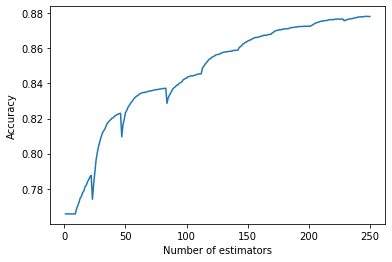

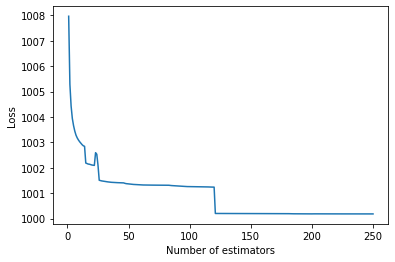

Percent correct with training set and tree size 9: 88.42%
Percent correct with test set and tree size 9: 9.53%
629.83 seconds elapsed


NameError: name 'train_accuracy' is not defined

In [7]:
""" 
Now we vary the size of the trees
We use 80% train, 20% test (The standard)
"""
all_train_accuracy_tree = list()
all_testing_accuracy_tree = list()

batches = [x / 10 for x in range(1, 3, 1)]

for batch_mult in batches:
    batch_train_accuracy = list()
    batch_test_accuracy = list()
    
    for dataset in range(3):
        hard_start = time()
        X, Y = get_dataset(2)

        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.8, random_state=2021)

        train_accuracy = []
        test_accuracy = []

        for treeSize in range(1, 10):
            start = time()
            print(f"Dataset: {dataset}; Batch Size: len(X)*{batch_mult}; Treesize: {treeSize}")
            model = Boost(n_estimators=250, base_learner=ShallowTree(treeSize)).update_fit(Xtrain, Ytrain, verbose=50, batch_size=round(len(Xtrain)*batch_mult))

            train_acc = model.accuracy(model.predict(Xtrain),Ytrain)
            train_accuracy.append(train_acc)
            test_acc = model.accuracy(model.predict(Xtest),Ytest)
            test_accuracy.append(test_acc)

            print(f"Percent correct with training set and tree size {treeSize}: {train_acc:.2%}")
            print(f"Percent correct with test set and tree size {treeSize}: {test_acc/len(test_accuracies):.2%}")
            print(f"{time()-start:.2f} seconds elapsed")

        batch_train_accuracy.append(train_accuracy)
        batch_test_accuracy.append(test_accuracy)
        print(f"{time()-hard_start:.2f} seconds to run")
        
    all_train_accuracy_tree.append(batch_train_accuracy)
    all_testing_accuracy_tree.append(batch_test_accuracy)